# Classifying seismic P-wave receiver functions using Ensemble Learning

The goal of this lab exercise is to get students familiar with the Scikit-Learn implementation of **Ensemble Learning** methods, in  particular, the **boosting** methods. 

Similar to previous two lab exercise, your task is to classify the P-wave receiver functions, which were computed based on the recorded seismic data, into two categories: good and bad. The entire data set consists of 12,597 receiver functions (i.e., seismic traces), each of which was visually examined and manually labeled as either good or bad by one of Prof. Aibing Li's PhD students, Ying Zhang, in the Department of Earth and Atmospheric Sciences at University of Houston. The good seismic traces are labled (or, encoded) as 1, and bad seismic traces are encoded as 0. <br>

After finishing this exercise, you can expect to <br>
1. be able to implement AdaBoost and Gradient Boosting using Scikit-Learn; and <br>
2. be able to fune tune the hyperparameters such as **max_depth**, **n_estimators** and **learning_rate**. <br>

<br>
Author: Jiajia Sun @ University of Houston, 03/07/2019

## Import data

In [1]:
import numpy as np
import h5py
with h5py.File("../Traces_qc.mat") as f:
    ampdata = [f[element[0]][:] for element in f["Data"]["amps"]]
    flag = [f[element[0]][:] for element in f["Data"]["Flags"]]
    ntr = [f[element[0]][:] for element in f["Data"]["ntr"]]
    time = [f[element[0]][:] for element in f["Data"]["time"]]
    staname = [f[element[0]][:] for element in f["Data"]["staname"]]
    
ampall = np.zeros((1,651))
flagall = np.zeros(1)
for i in np.arange(201):
    ampall = np.vstack((ampall, ampdata[i]))
    flagall = np.vstack((flagall, flag[i]))
amp_data = np.delete(ampall, 0, 0)
label_data = np.delete(flagall, 0, 0)

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
np.random.seed(42)
all_data = np.append(amp_data,label_data,1) # put all the seismic traces and their lables into one matrix.

Next, we randomly permute the data (i.e., the rows in the matrix *all_data* that was just construted above).

In [3]:
all_data_permute = all_data[np.random.permutation(all_data.shape[0]),:] 

Similar to previous lab exercises, we split the whole data set into training and validation sets. BTW, in Scikit-Learn, there is a module called [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) that can automatically split the dataset for you. But for this exercise, we are not going to use that. To keep things consistent, we do the splitting in the same way as in previous lab exercises.

In [4]:
X_train = all_data_permute[:10000,:-1]
y_train = all_data_permute[:10000,-1]

X_validation = all_data_permute[10000:,:-1]
y_validation = all_data_permute[10000:,-1]

## Train an AdaBoostClassifier

To learn more about AdaBoostClassifier as implemented in Scikit-Learn, please click [here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html). <br>

### Standard AdaBoostClassifier
One thing you need to specify in order to run AdaBoostClassifier is the base estimator. If you forget what a base estimator is, please refer to Slide 52. 

Now, let us import AdaBoostClassifier.

In [5]:
from sklearn.ensemble import AdaBoostClassifier

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


For illustration purposes, I am going to use [DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) as my base estimator. The number of Decision Trees in my ensemble is 200. Again, this is only for illustrating how to set up **AdaBoostClassifier**. Please feel free to use any other classification algorithm. <br>
<br>
Because I decide to use **DecisionTreeClassifier** as my base estimator, I also need to import **DecisionTreeClassifier** from sklearn.

In [6]:
from sklearn.tree import DecisionTreeClassifier

The next line of code shows how I set up the **AdaBoostClassifier**.

In [7]:
rf_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2), n_estimators=100, learning_rate = 0.5, random_state = 42)

As always, please set your *random_state* = 42, so that whenven random sampling is involved, we all get the same sampling results.

One more thing before we proceed to train an **AdaBoostClassifier**. That is, learning rate. For **AdaBoost**, remember that at each iteration we adaptively adjust the weights on each sample, depending on how well they were classified by the previous predictor. The learning rate decides how much adjusment is going to happen to the samples. <br>
<br>
For example, the following figure shows the decision boundaries of five consecutive predictors on the [moons](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) dataset. In the left figure, the decision boundaries learned from these five consecutive predictors are indicated by the integer numbers. We observe that, the first classifier gets many instances wrongly labeled. Then, at the next iteration, the weights of these misclassified lables get boosted. The second classifier, therefore, ends up doing a better job classifying these instances. This process repeats until all the **n_estimators** are included in the ensemble. The plot on the right represents the same sequence but with learning rate halved. That is, the weights on the misclassified instances only get boosted half as much at every iteration. That is why you observe that the decision boundaries learned with **learning_rate** = 0.5 are updated more slowly.<br> 

<img src = "Learning_Rate.png">

Now, we are ready to train an AdaBoostClassifier.

In [8]:
rf_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=100, random_state=42)

Now, make predictions on the validation dataset using the AdaBoostClassifier that you just trained above.

In [9]:
y_pred = rf_clf.predict(X_validation)

As usual, print out the classification report.

In [10]:
from sklearn.metrics import classification_report
print(classification_report(y_validation, y_pred, target_names=['bad','good']))

             precision    recall  f1-score   support

        bad       0.93      0.94      0.93      1994
       good       0.79      0.75      0.77       603

avg / total       0.90      0.90      0.90      2597



You can calculate the prediction error on training data as follows.

In [11]:
1 - rf_clf.score(X_train, y_train)

0.04920000000000002

Similarly, the prediction error on validation data can be calculated as follow.

In [12]:
1 - rf_clf.score(X_validation,y_validation)

0.10319599537928381

### AdaBoostClassifier with balanced class_weight

Alternatively, you can train another AdaBoostClassifier by setting **class_weight** to **'balanced'**. You did something similar in previous lab exercise for Random Forests. This parameter can be used to balance the training samples for which the number of samples in each classe is very different from each other.

In [13]:
rf_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2, class_weight = 'balanced'), n_estimators=100, learning_rate = 0.5, random_state = 42)

In [14]:
rf_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=100, random_state=42)

In [15]:
y_pred = rf_clf.predict(X_validation)

In [16]:
print(classification_report(y_validation, y_pred, target_names=['bad','good']))

             precision    recall  f1-score   support

        bad       0.95      0.90      0.93      1994
       good       0.72      0.85      0.78       603

avg / total       0.90      0.89      0.89      2597



Feature ranking:
1. feature 49 (0.053462)
2. feature 50 (0.038199)
3. feature 54 (0.019763)
4. feature 51 (0.016490)
5. feature 99 (0.015265)
6. feature 62 (0.015223)
7. feature 47 (0.014685)
8. feature 48 (0.014045)
9. feature 53 (0.014040)
10. feature 155 (0.013670)


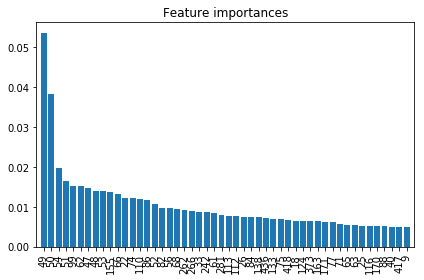

In [18]:
# The following code is based on a modification of the codes in this webpage
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
import matplotlib.pyplot as plt
plt.figure()
plt.title("Feature importances")
plt.bar(range(50), importances[indices][:50])
plt.xticks(range(50), indices, rotation = 90)
plt.xlim([-1, 50])
plt.tight_layout()
plt.show()

In [19]:
# The prediction error on training data
1 - rf_clf.score(X_train, y_train)

0.06489999999999996

In [20]:
# The prediction error on validation data
1 - rf_clf.score(X_validation,y_validation)

0.11166730843280703

## Train a GradientBoostingClassifier
To learn more about how GradientBoostingClassifier is implemented in Scikit-Learn, please click [here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html).

The first thing to do is import **GradientBoostingClassifier** from Scikit-Learn.

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

Next, set up **GradientBoostingClassifier** by assigning values to the hyperparameters such as max_depth, n_estimators, learning_rate, etc. **Note:** For gradient boosting, you do not need to choose the base estimator, beccause the base estimator has been defaulted to **Decision Trees**. Also, for **GradientBoostingClassifier**, there is no **class_weight**.<br>
<br>
For **GradientBoostingClassifier**, the learning_rate scales (more precisely, shrinks) the contribution of each tree. If **learning_rate** is too small, such as 0.1, you will need many trees in the ensemble to fit the training data. The following figure shows two ensembles trained by **GradientBoostingRegressor** with **learning_rate** = 0.1. The one on the left does not have enough trees to fit the training data, while the one on the right has too many trees and overfits the training data. <br>

<img src = "GBlearning.PNG">

To give you a better understanding of **learning_rate**, the following example compares the predictors learned by **GradientBoostingRegressor** with two different learning rates. 
<br>

<img src = "GBlearning2.png">

With a good understanding of these hyperparameters, now we are ready to set up our **GradientBoostingClassifier**.

In [22]:
gtb = GradientBoostingClassifier(max_depth = 2, n_estimators = 200, learning_rate = 0.5, random_state=42)

In [23]:
gtb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

After training is done, we need to use the trained predictor (or, classifier) to make predictions on our validation dataset.

In [24]:
y_pred = gtb.predict(X_validation)

Now, we can print out the classification report.

In [25]:
print(classification_report(y_validation, y_pred, target_names=['bad','good']))

             precision    recall  f1-score   support

        bad       0.92      0.94      0.93      1994
       good       0.79      0.74      0.76       603

avg / total       0.89      0.89      0.89      2597



In [26]:
# The prediction error on training data
1 - gtb.score(X_train, y_train)

0.01880000000000004

In [27]:
# The prediction error on validation data
1 - gtb.score(X_validation,y_validation)

0.10589141316904116

## Task
The prediction errors on validation dataset that I obtained are: 0.10319599537928381 for standard **AdaBoostClassifier**, 0.11166730843280703 for **AdaBoostClassifier** with **balanced class_weight**, and 0.10589141316904116 for **GradientBoostingClassifier**. So, the lowest error that I achieved is 0.10319599537928381, which corresponds to a prediction accuracy of 1-0.10319599537928381 = 0.8968. <br>

<font color = red>**Your task**</font>: do whatever you can to come up with a predictor (or synonymously, classifier) with better predication accuracy. By 'better', I mean better than 0.8968. <font color = red>**(100 points)**</font> <br>
<br>
**HINT:** Feel free to try anything you can think of. For example, it is up to you to choose between **AdaBoostClassifier** and **GradientBoostingClassifier**. Or, if you like, you can even create your own ensemble by combining, say, support vector machine, logistic regression and decision trees. Also, feel free to try different values for the hyperparameters such as **max_depth**, **n_estimators**, **learning_rate**, and **class_weight** (not available for Gradient Boosting).

Note: Please write down your code below. <font color=red>**DO NOT**</font> change the above codes.

## Bonus
If you achieve a prediction accuracy of **91% or above**, you get <font color = red>**10 bonus points**</font>. <br>
<br>
If you achieve a prediction accuracy of **92% or above**, you will get a <font color = red>**$20 gift card**</font> from a merchant of your choice. (Limited to the first five submissions) <br>
<br>
If you achieve a prediction accuracy of **93% or above**, I will buy you <font color = red>**a dinner at Eric's**</font>.

## Acknowledgments
I would like to thank Ying Zhang for manually labeling all the seismic traces, and Prof. Aibing Li for making this data set available to the students in this class. I also want to thank Dr. Tianyuan Guan for sponsoring this event (i.e., the gift cards and dinners)! <br>

<img src = "photo.png">